In [1]:
##rerences for the code are there in the readme file

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark import SparkContext

# For regression and other possible ML tools (Spark)
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics

# Important for managing features  (Spark)
from pyspark.ml.feature import OneHotEncoder, StringIndexer,Bucketizer
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.ml.feature import FeatureHasher

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("project_key_example")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [4]:
from pymongo import MongoClient
client = MongoClient()
db = client.Project_data
collection = db.e_commerce_stored_data
electronics_dataframe = pd.DataFrame(list(collection.find()))
electronics_dataframe.head()

,_id,event_time,event_type,product_id,category_id,category_code,price,user_id,user_session,brand
0,6184ca647b6617b2df507d0b,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,31.90,1515915625519388267,LJuJVLEjPT,NaN
1,6184ca647b6617b2df507d0c,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,17.16,1515915625519380411,tdicluNnRY,zalman
2,6184ca647b6617b2df507d0d,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,9.81,1515915625513238515,4TMArHtXQy,NaN
3,6184ca647b6617b2df507d0e,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,113.81,1515915625519014356,aGFYrNgC08,pantum
4,6184ca647b6617b2df507d0f,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,15.87,1515915625510743344,aa4mmk0kwQ,cameronsino


In [5]:
electronics_dataframe.dropna(subset = ['price'], inplace=True)
electronics_dataframe.dropna(subset = ['category_code'], inplace=True)
electronics_dataframe.dropna(subset = ['brand'], inplace=True)
electronics_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516349 entries, 1 to 885128
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   _id            516349 non-null  object
 1   event_time     516349 non-null  object
 2   event_type     516349 non-null  object
 3   product_id     516349 non-null  object
 4   category_id    516349 non-null  object
 5   category_code  516349 non-null  object
 6   price          516349 non-null  object
 7   user_id        516349 non-null  object
 8   user_session   516256 non-null  object
 9   brand          516349 non-null  object
dtypes: object(10)
memory usage: 43.3+ MB


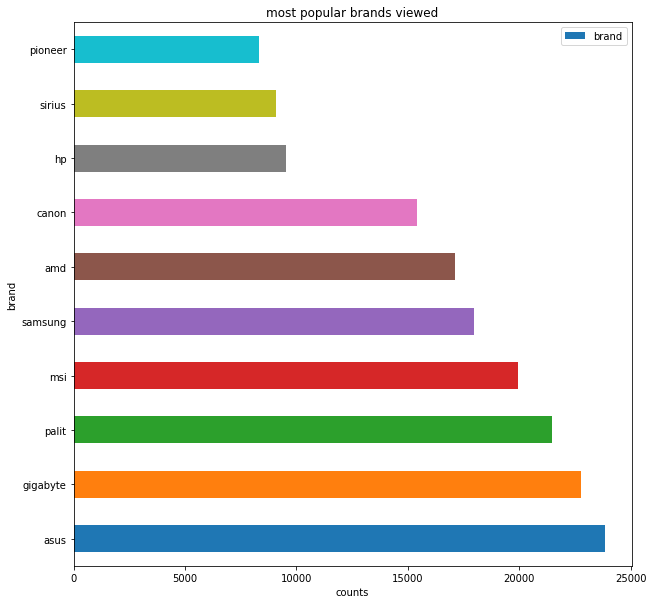

In [6]:
top_brands = electronics_dataframe[electronics_dataframe['event_type'] == 'view'].groupby('brand')['brand'].count().sort_values(ascending=False)
top_brands.head(10).plot(kind = 'barh',figsize=(10,10),color=['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9'])
plt.title('most popular brands viewed')
plt.xlabel('counts')
plt.legend()
plt.show()

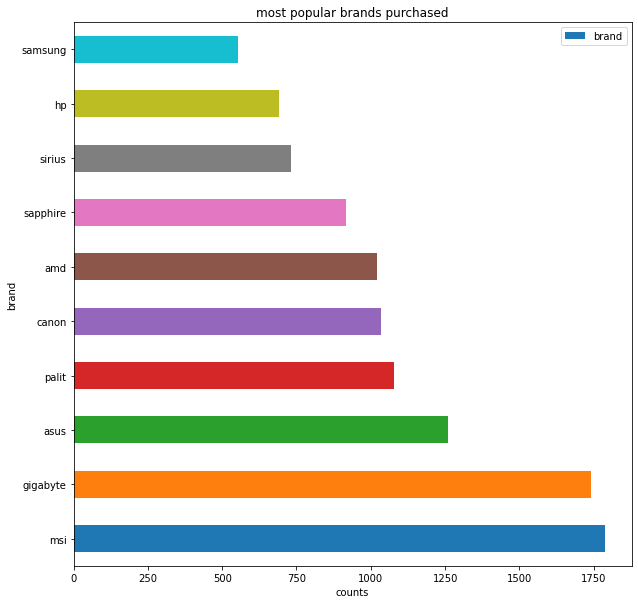

In [7]:
top_viewd_brands = electronics_dataframe[electronics_dataframe['event_type'] == 'purchase'].groupby('brand')['brand'].count().sort_values(ascending=False)
top_viewd_brands.head(10).plot(kind = 'barh',figsize=(10,10),color=['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9'])
plt.title('most popular brands purchased')
plt.xlabel('counts')
plt.legend()
plt.show()

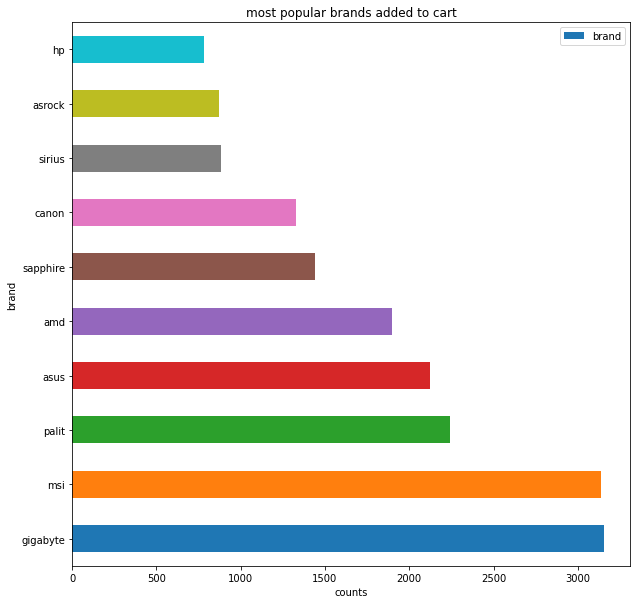

In [8]:
brands_in_cart = electronics_dataframe[electronics_dataframe['event_type'] == 'cart'].groupby('brand')['brand'].count().sort_values(ascending=False)
brands_in_cart.head(10).plot(kind = 'barh',figsize=(10,10),color=['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7', 'C8', 'C9'])
plt.xlabel('counts')
plt.title('most popular brands added to cart')
plt.legend()
plt.show()

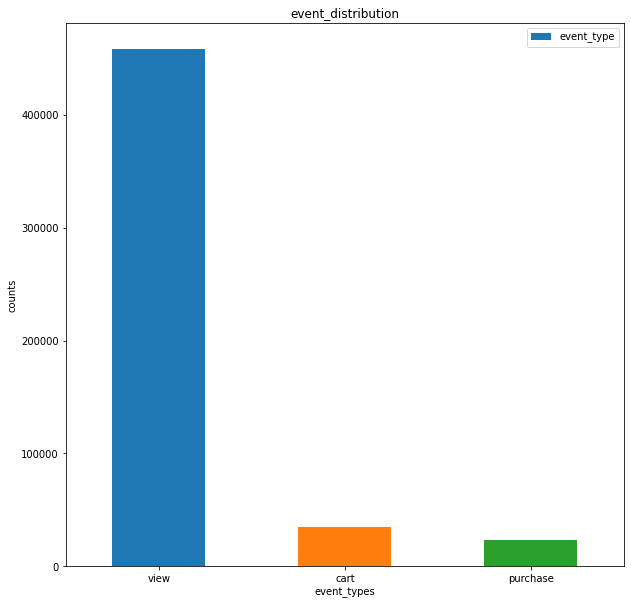

In [9]:
electronics_dataframe['event_type'].value_counts().plot(kind = 'bar',figsize=(10,10),color=['C0', 'C1', 'C2'])
plt.ylabel('counts')
plt.xlabel('event_types')
plt.xticks(rotation=360)
plt.title('event_distribution')
plt.legend()
plt.show()

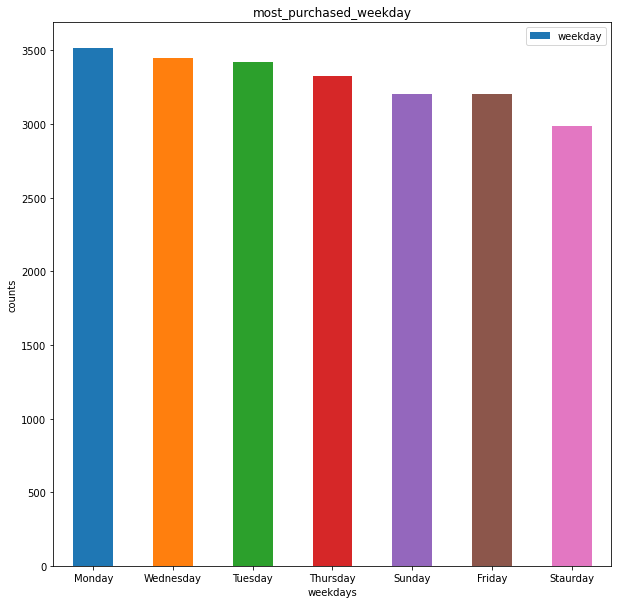

In [10]:
electronics_dataframe['weekday'] = pd.to_datetime(electronics_dataframe['event_time']).apply(lambda x: x.weekday())
weekdays_dict={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Staurday',6:'Sunday'}
electronics_dataframe.head()

#to check the most busiest days for the  sales


electronics_dataframe['weekday'].replace(weekdays_dict,inplace=True)
electronics_dataframe['weekday'][electronics_dataframe['event_type']=='purchase'].value_counts().plot(kind = 'bar',figsize=(10,10),color=['C0', 'C1', 'C2', 'C3', 'C4','C5', 'C6'])
plt.ylabel('counts')
plt.xlabel('weekdays')
plt.title('most_purchased_weekday')
plt.xticks(rotation=360)
plt.legend()
plt.show()

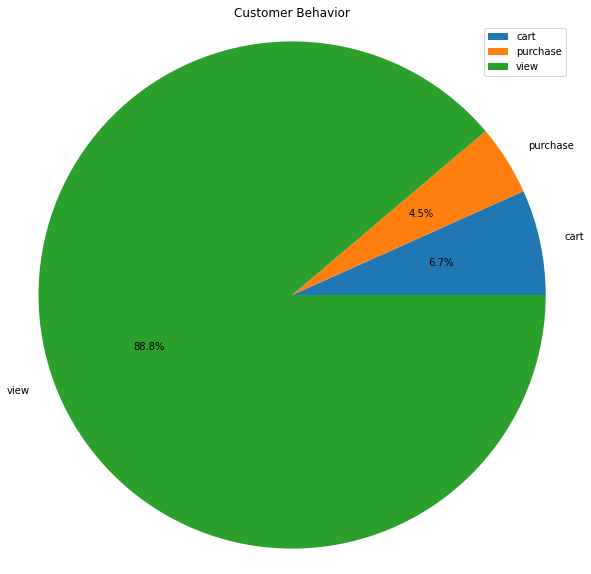

In [11]:
#cleaning the data
electronics_dataframe.drop(['_id'],axis=1,inplace=True)
electronics_dataframe["High_level_description"] = electronics_dataframe["category_code"].str.split(".",expand=True)[0].astype('category')
electronics_dataframe["product_category"] = electronics_dataframe["category_code"].str.split(".",expand=True)[1].astype('category')
electronics_dataframe["product"] = electronics_dataframe["category_code"].str.split(".",expand=True)[2].astype('category')
electronics_dataframe.drop(['category_code'],axis=1,inplace=True)
electronics_dataframe.head()

e_type=electronics_dataframe.groupby('event_type').size().reset_index(name='total')
e_type.head(3)

plt.figure(figsize=(10,10))
plt.pie(e_type['total'],labels=e_type['event_type'],autopct='%1.1f%%')
plt.title('Customer Behavior')
plt.axis('equal')
plt.legend()
plt.show()

In [12]:
##indexing
brand_list=electronics_dataframe.brand.unique().tolist()
#print(type(use_session_list))
prod_ind=[]
brand_dict={}
count=0
for prod in brand_list:
    brand_dict[prod]=count
    count=count+1
         
electronics_dataframe["brand"].replace(brand_dict,inplace=True)

high_lev_desc=electronics_dataframe.High_level_description.unique().tolist()
high_ind=[]
High_lev_desc_dict={}
high_count=0
for prod in high_lev_desc:
    High_lev_desc_dict[prod]=high_count
    high_count=high_count+1
        
electronics_dataframe["High_level_description"].replace(High_lev_desc_dict,inplace=True)

category_desc=electronics_dataframe.category_id.unique().tolist()

category_desc_dict={}
cat_count=0
for prod in category_desc:
    category_desc_dict[prod]=cat_count
    cat_count=cat_count+1
        
electronics_dataframe["category_id"].replace(category_desc_dict,inplace=True)

product_desc=electronics_dataframe.product_category.unique().tolist()

product_desc_dict={}
prod_count=0
for prod in product_desc:
    product_desc_dict[prod]=prod_count
    prod_count=prod_count+1
        
electronics_dataframe["product_category"].replace(product_desc_dict,inplace=True)

electronics_dataframe.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,brand,weekday,High_level_description,product_category,product
1,2020-09-24 11:57:26 UTC,view,139905,0,17.16,1515915625519380411,tdicluNnRY,0,Thursday,0,0,cooler
3,2020-09-24 11:57:33 UTC,view,635807,1,113.81,1515915625519014356,aGFYrNgC08,1,Thursday,0,1,printer
5,2020-09-24 11:57:59 UTC,view,664325,2,52.33,1515915625519388062,vnkdP81DDW,2,Thursday,1,2,saw
7,2020-09-24 11:58:24 UTC,view,716611,3,53.14,1515915625519388882,kVBeYDPcBw,3,Thursday,0,3,router
9,2020-09-24 11:58:31 UTC,view,716611,3,53.14,1515915625519388929,F3VB9LYp39,3,Thursday,0,3,router


In [13]:
weekday_desc=electronics_dataframe.weekday.unique().tolist()

weekday_desc_dict={}
week_count=0
for prod in weekday_desc:
    weekday_desc_dict[prod]=week_count
    week_count=week_count+1
        
electronics_dataframe["weekday"].replace(weekday_desc_dict,inplace=True)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
electronics_dataframe['product']=le.fit_transform(electronics_dataframe['product'])
electronics_dataframe['user_id']=le.fit_transform(electronics_dataframe['user_id'])
#electronics_dataframe['product']=le.fit_transform(electronics_dataframe['product'])

electronics_dataframe.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,brand,weekday,High_level_description,product_category,product
1,2020-09-24 11:57:26 UTC,view,139905,0,17.16,4344,tdicluNnRY,0,0,0,0,12
3,2020-09-24 11:57:33 UTC,view,635807,1,113.81,4224,aGFYrNgC08,1,0,0,1,47
5,2020-09-24 11:57:59 UTC,view,664325,2,52.33,4351,vnkdP81DDW,2,0,1,2,53
7,2020-09-24 11:58:24 UTC,view,716611,3,53.14,4352,kVBeYDPcBw,3,0,0,3,52
9,2020-09-24 11:58:31 UTC,view,716611,3,53.14,4353,F3VB9LYp39,3,0,0,3,52


In [14]:
electronics_machine_learning_dataframe = electronics_dataframe.loc[electronics_dataframe["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
electronics_machine_learning_dataframe["is_purchased"] = np.where(electronics_machine_learning_dataframe["event_type"]=="purchase",1,0)
electronics_machine_learning_dataframe["is_purchased"] = electronics_machine_learning_dataframe.groupby(["user_session","product_id"])["is_purchased"].transform("max")
electronics_machine_learning_dataframe["is_purchased"]=electronics_machine_learning_dataframe["is_purchased"].fillna(0)
electronics_machine_learning_dataframe.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,brand,weekday,High_level_description,product_category,product,is_purchased
37,2020-09-24 12:02:53 UTC,cart,1507291,9,217.57,4360,UzabYgCPva,9,0,0,0,46,0.0
45,2020-09-24 12:04:10 UTC,purchase,1507291,9,217.57,4360,xn6SHCnZtk,9,0,0,0,46,1.0
59,2020-09-24 12:08:24 UTC,cart,136700,6,77.73,4363,0KdrxeTB4x,7,0,0,0,37,0.0
71,2020-09-24 12:12:16 UTC,cart,822426,17,123.35,3185,2gngxS29Ts,19,0,0,1,6,1.0
75,2020-09-24 12:13:03 UTC,cart,1283197,19,123.79,4331,3jFpdbozOd,22,0,0,1,40,1.0


In [15]:
electronics_machine_learning_dataframe["price"]=electronics_machine_learning_dataframe["price"].astype(float)
electronics_machine_learning_dataframe = electronics_dataframe.loc[electronics_dataframe["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
electronics_machine_learning_dataframe["is_purchased"] = np.where(electronics_machine_learning_dataframe["event_type"]=="purchase",1,0)
electronics_machine_learning_dataframe["is_purchased"] = electronics_machine_learning_dataframe.groupby(["user_session","product_id"])["is_purchased"].transform("max")
electronics_machine_learning_dataframe["is_purchased"]=electronics_machine_learning_dataframe["is_purchased"].fillna(0)
electronics_machine_learning_dataframe.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,brand,weekday,High_level_description,product_category,product,is_purchased
37,2020-09-24 12:02:53 UTC,cart,1507291,9,217.57,4360,UzabYgCPva,9,0,0,0,46,0.0
45,2020-09-24 12:04:10 UTC,purchase,1507291,9,217.57,4360,xn6SHCnZtk,9,0,0,0,46,1.0
59,2020-09-24 12:08:24 UTC,cart,136700,6,77.73,4363,0KdrxeTB4x,7,0,0,0,37,0.0
71,2020-09-24 12:12:16 UTC,cart,822426,17,123.35,3185,2gngxS29Ts,19,0,0,1,6,1.0
75,2020-09-24 12:13:03 UTC,cart,1283197,19,123.79,4331,3jFpdbozOd,22,0,0,1,40,1.0


In [16]:
electronics_machine_learning_dataframe["price"]=electronics_machine_learning_dataframe["price"].astype(float)
electronics_machine_learning_dataframe = electronics_machine_learning_dataframe.loc[electronics_machine_learning_dataframe["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
electronics_machine_learning_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31404 entries, 37 to 885088
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_time              31404 non-null  object 
 1   event_type              31404 non-null  object 
 2   product_id              31404 non-null  object 
 3   category_id             31404 non-null  int64  
 4   price                   31404 non-null  float64
 5   user_id                 31404 non-null  int32  
 6   user_session            31402 non-null  object 
 7   brand                   31404 non-null  int64  
 8   weekday                 31404 non-null  int64  
 9   High_level_description  31404 non-null  int64  
 10  product_category        31404 non-null  int64  
 11  product                 31404 non-null  int32  
 12  is_purchased            31404 non-null  float64
dtypes: float64(2), int32(2), int64(5), object(4)
memory usage: 3.1+ MB


In [17]:
users_who_purchased = electronics_dataframe.loc[electronics_dataframe["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
users_who_purchased.dropna(how='any', inplace=True)
users_who_purchased_all_activity = electronics_dataframe.loc[electronics_dataframe['user_id'].isin(users_who_purchased['user_id'])]
activity_in_session = users_who_purchased_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})
electronics_machine_learning_dataframe = electronics_machine_learning_dataframe.merge(activity_in_session, on='user_session', how='left')
electronics_machine_learning_dataframe['activity_count'] = electronics_machine_learning_dataframe['activity_count'].fillna(0).astype(int)
electronics_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516349 entries, 1 to 885128
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   event_time              516349 non-null  object
 1   event_type              516349 non-null  object
 2   product_id              516349 non-null  object
 3   category_id             516349 non-null  int64 
 4   price                   516349 non-null  object
 5   user_id                 516349 non-null  int32 
 6   user_session            516256 non-null  object
 7   brand                   516349 non-null  int64 
 8   weekday                 516349 non-null  int64 
 9   High_level_description  516349 non-null  int64 
 10  product_category        516349 non-null  int64 
 11  product                 516349 non-null  int32 
dtypes: int32(2), int64(5), object(5)
memory usage: 47.3+ MB


In [18]:
#soark code
df_schema = StructType([StructField("event_time", StringType(), True)\
                       ,StructField("event_type", StringType(), True)\
                       ,StructField("product_id", StringType(), True)\
                       ,StructField("category_id", IntegerType(), True)\
                       ,StructField("price", DoubleType(), True)\
                       ,StructField("user_id", IntegerType(), True)\
                       ,StructField("user_session", StringType(), True)\
                       ,StructField("brand", IntegerType(), True)\
                        ,StructField("weekday", IntegerType(), True)\
                        ,StructField("High_level_description", IntegerType(), True)\
                        ,StructField("product_category", IntegerType(), True)\
                        ,StructField("product", IntegerType(), True)\
                        ,StructField("is_purchased", DoubleType(), True)\
                       ,StructField("activity_count", StringType(), True)])
electronics_data=spark.createDataFrame(electronics_machine_learning_dataframe,schema=df_schema)
display(electronics_data)
electronics_data.printSchema()

DataFrame[event_time: string, event_type: string, product_id: string, category_id: int, price: double, user_id: int, user_session: string, brand: int, weekday: int, High_level_description: int, product_category: int, product: int, is_purchased: double, activity_count: string]

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- brand: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- High_level_description: integer (nullable = true)
 |-- product_category: integer (nullable = true)
 |-- product: integer (nullable = true)
 |-- is_purchased: double (nullable = true)
 |-- activity_count: string (nullable = true)



In [19]:
brand_dist=electronics_data.select('brand','is_purchased').groupBy("brand").count()
brand_dist.orderBy('count',ascending=False).show()
#from pyspark.ml.feature import FeatureHasher
hasher = FeatureHasher(inputCols=["event_type", "user_id", "category_id","price",'brand','weekday','High_level_description','product_category','product','activity_count'],
                       outputCol="features")

featurized = hasher.transform(electronics_data)


+-----+-----+
|brand|count|
+-----+-----+
|   61| 2878|
|   18| 2864|
|  135| 2106|
|   27| 1941|
|   13| 1685|
|   71| 1295|
|   34| 1199|
|   15|  790|
|    7|  759|
|   20|  704|
|   39|  673|
|   42|  559|
|   16|  520|
|  169|  418|
|   57|  395|
|   25|  388|
|   48|  363|
|   19|  333|
|   62|  331|
|    1|  269|
+-----+-----+
only showing top 20 rows



In [20]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(featurized)
scaledData = scalerModel.transform(featurized)


In [21]:
from pyspark.ml.classification import LogisticRegression
splits = scaledData.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]


lr = LogisticRegression(featuresCol = 'features', labelCol = 'is_purchased', maxIter=10)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(test_df)
#predictions.show()

predictions.select('event_type', 'product_category', 'is_purchased','prediction').show(30)


+----------+----------------+------------+----------+
|event_type|product_category|is_purchased|prediction|
+----------+----------------+------------+----------+
|      cart|               0|         0.0|       0.0|
|      cart|               1|         1.0|       1.0|
|      cart|               1|         1.0|       0.0|
|      cart|               9|         1.0|       1.0|
|      cart|               9|         1.0|       1.0|
|      cart|              10|         1.0|       1.0|
|      cart|              13|         0.0|       0.0|
|      cart|              21|         1.0|       1.0|
|      cart|               1|         1.0|       1.0|
|      cart|              11|         1.0|       1.0|
|      cart|               0|         1.0|       0.0|
|      cart|               0|         1.0|       1.0|
|      cart|               1|         1.0|       0.0|
|      cart|               0|         0.0|       1.0|
|      cart|              17|         1.0|       1.0|
|      cart|               1

the area under the ROC curve is 0.7219012894694555
              precision    recall  f1-score   support

         0.0       0.72      0.58      0.64      5158
         1.0       0.59      0.73      0.65      4338

    accuracy                           0.65      9496
   macro avg       0.66      0.65      0.65      9496
weighted avg       0.66      0.65      0.65      9496

the accuracy of the LogisticRegression model is 0.6474304970513901


<Figure size 1440x1440 with 0 Axes>

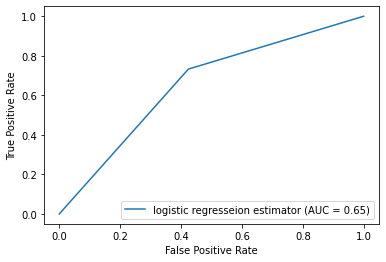

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn import metrics


evaluator = BinaryClassificationEvaluator(labelCol='is_purchased', metricName='areaUnderROC')
print('the area under the ROC curve is',evaluator.evaluate(predictions))
y_true = predictions.select(['is_purchased']).toPandas()
y_pred = predictions.select(['prediction']).toPandas()
print(classification_report(y_true, y_pred))
print('the accuracy of the LogisticRegression model is', accuracy_score(y_true, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)
log_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='logistic regresseion estimator')
plt.figure(figsize=(20,20))
log_display.plot()
plt.show()

the area under the ROC cureve is 0.7169992103829727
              precision    recall  f1-score   support

         0.0       0.73      0.54      0.62      5158
         1.0       0.58      0.77      0.66      4338

    accuracy                           0.64      9496
   macro avg       0.66      0.65      0.64      9496
weighted avg       0.66      0.64      0.64      9496

the accuracy of the LogisticRegression model is 0.6436394271272114


<Figure size 720x720 with 0 Axes>

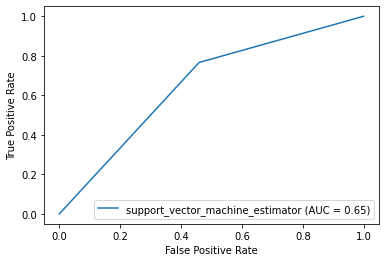

In [39]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1,featuresCol='features', labelCol='is_purchased')
lsvcModel = lsvc.fit(train_df)
svc_predictions = lsvcModel.transform(test_df)
#predictions.show()
svc_evaluator = BinaryClassificationEvaluator(labelCol='is_purchased', metricName='areaUnderROC')
print('the area under the ROC cureve is',svc_evaluator.evaluate(svc_predictions))
svc_predictions.select('event_type', 'product_category', 'is_purchased', 'price','prediction')
svc_y_true = svc_predictions.select(['is_purchased']).collect()
svc_pred = svc_predictions.select(['prediction']).collect()
print(classification_report(svc_y_true, svc_pred))
print('the accuracy of the LogisticRegression model is',accuracy_score(svc_y_true, svc_pred))
fpr_svc, tpr_svc, thresholds = metrics.roc_curve(svc_y_true, svc_pred)
roc_auc_svc = metrics.auc(fpr_svc, tpr_svc)
display_svc = metrics.RocCurveDisplay(fpr=fpr_svc, tpr=tpr_svc, roc_auc=roc_auc_svc,estimator_name='support_vector_machine_estimator')
plt.figure(figsize=(10,10))
display_svc.plot()
plt.show()

In [24]:
recommendation_dataframe = electronics_dataframe.loc[electronics_dataframe["event_type"].isin(["view"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
recommendation_dataframe['price']=recommendation_dataframe['price'].astype('float').astype('int')
recommendation_dataframe['user_id']=recommendation_dataframe['user_id'].astype('int')
recommendation_dataframe["price"].describe()
conditions = [
    (recommendation_dataframe['price'] <= 30),
    (recommendation_dataframe['price'] > 30) & (recommendation_dataframe['price'] <= 83),
    (recommendation_dataframe['price'] > 83) & (recommendation_dataframe['price'] <= 230),
    (recommendation_dataframe['price'] > 230)
    ]
values = [4,3,2,1]
recommendation_dataframe['tier'] = np.select(conditions, values)
recommendation_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358610 entries, 1 to 885126
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   event_time              358610 non-null  object
 1   event_type              358610 non-null  object
 2   product_id              358610 non-null  object
 3   category_id             358610 non-null  int64 
 4   price                   358610 non-null  int32 
 5   user_id                 358610 non-null  int32 
 6   user_session            358529 non-null  object
 7   brand                   358610 non-null  int64 
 8   weekday                 358610 non-null  int64 
 9   High_level_description  358610 non-null  int64 
 10  product_category        358610 non-null  int64 
 11  product                 358610 non-null  int32 
 12  tier                    358610 non-null  int32 
dtypes: int32(4), int64(5), object(4)
memory usage: 32.8+ MB


In [25]:
clus_schema = StructType([StructField("event_time", StringType(), True)\
                       ,StructField("event_type", StringType(), True)\
                       ,StructField("product_id", StringType(), True)\
                       ,StructField("category_id", IntegerType(), True)\
                       ,StructField("price", IntegerType(), True)\
                       ,StructField("user_id", IntegerType(), True)\
                       ,StructField("user_session", StringType(), True)\
                       ,StructField("brand", IntegerType(), True)\
                        ,StructField("weekday", IntegerType(), True)\
                        ,StructField("High_level_description", IntegerType(), True)\
                        ,StructField("product_category", IntegerType(), True)\
                        ,StructField("product", IntegerType(), True)\
                        ,StructField("tier", IntegerType(), True)])
clus_data=spark.createDataFrame(recommendation_dataframe,schema=clus_schema)
clus_data.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- brand: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- High_level_description: integer (nullable = true)
 |-- product_category: integer (nullable = true)
 |-- product: integer (nullable = true)
 |-- tier: integer (nullable = true)



In [26]:



clust_hasher = FeatureHasher(inputCols=['product_category','product','price'],
                       outputCol="features")

clust_featurized = clust_hasher.transform(clus_data)
clust_featurized.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- brand: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- High_level_description: integer (nullable = true)
 |-- product_category: integer (nullable = true)
 |-- product: integer (nullable = true)
 |-- tier: integer (nullable = true)
 |-- features: vector (nullable = true)



In [27]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
output_list=[]
center_list=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(clust_featurized)
    
    output=KMeans_fit.transform(clust_featurized)
    output_list.append([output])
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    centers = KMeans_fit.clusterCenters()
    for center in centers:
        center_list.append([center])
        
    
    print("Silhouette Score:",i,score)

Silhouette Score: 2 0.9911957854371466
Silhouette Score: 3 0.7897140834624916
Silhouette Score: 4 0.8495399661068637
Silhouette Score: 5 0.8501928130383872
Silhouette Score: 6 0.8281453175065134
Silhouette Score: 7 0.770909941540543
Silhouette Score: 8 0.7766416396301933
Silhouette Score: 9 0.7711850901708651


Text(0, 0.5, 'cost')

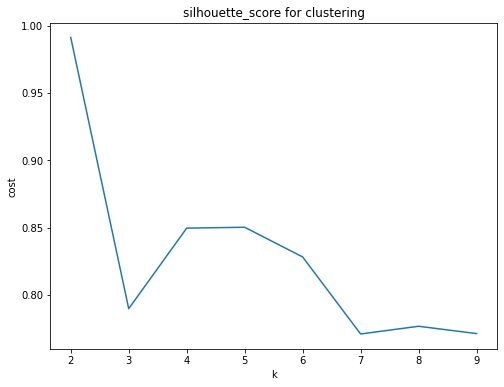

In [28]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
plt.title('silhouette_score for clustering')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [29]:
new_dataframe=clus_data
new_dataframe.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- brand: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- High_level_description: integer (nullable = true)
 |-- product_category: integer (nullable = true)
 |-- product: integer (nullable = true)
 |-- tier: integer (nullable = true)



In [30]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=[
    'product_category',
 'product',
'price'], outputCol='features')
assembled_data=assemble.transform(new_dataframe)
assembled_data.show(2)

+--------------------+----------+----------+-----------+-----+-------+------------+-----+-------+----------------------+----------------+-------+----+----------------+
|          event_time|event_type|product_id|category_id|price|user_id|user_session|brand|weekday|High_level_description|product_category|product|tier|        features|
+--------------------+----------+----------+-----------+-----+-------+------------+-----+-------+----------------------+----------------+-------+----+----------------+
|2020-09-24 11:57:...|      view|    139905|          0|   17|   4344|  tdicluNnRY|    0|      0|                     0|               0|     12|   4| [0.0,12.0,17.0]|
|2020-09-24 11:57:...|      view|    635807|          1|  113|   4224|  aGFYrNgC08|    1|      0|                     0|               1|     47|   2|[1.0,47.0,113.0]|
+--------------------+----------+----------+-----------+-----+-------+------------+-----+-------+----------------------+----------------+-------+----+----------

In [31]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [32]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [36]:
from pyspark.ml.clustering import KMeans
KMeans_=KMeans(featuresCol='features', k=5) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)
centers = KMeans_Model.clusterCenters()
KMeans_Assignments.select('user_id','price','brand','product','prediction').show(10)
print("Cluster Centers: ")
for center in centers:
    print(center)

+-------+-----+-----+-------+----------+
|user_id|price|brand|product|prediction|
+-------+-----+-----+-------+----------+
|   4344|   17|    0|     12|         0|
|   4224|  113|    1|     47|         0|
|   4351|   52|    2|     53|         0|
|   4352|   53|    3|     52|         0|
|   4353|   53|    3|     52|         0|
|   4354|  268|    4|     47|         0|
|   4348|  635|    5|     63|         3|
|   4355|   92|    6|     45|         0|
|   4320|   73|    7|     37|         0|
|   4356|   40|    5|     67|         0|
+-------+-----+-----+-------+----------+
only showing top 10 rows

Cluster Centers: 
[  6.29359007  50.39724747 103.02050925]
[2.50000e+00 4.95000e+01 5.36805e+04]
[   6.66405485   56.14887365 3136.80509305]
[  2.8096032   60.37826644 559.33053123]
[4.0000e+00 6.3000e+01 2.7775e+04]


In [37]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

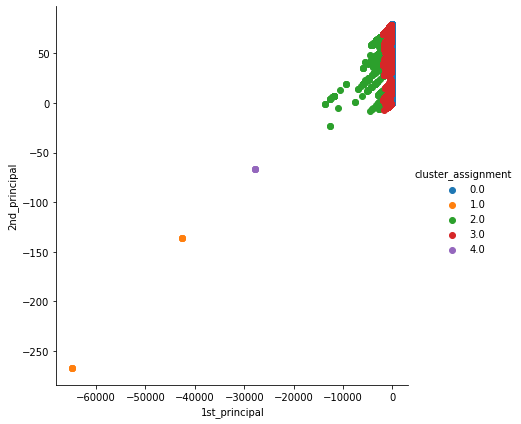

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()